# Extraction of topics from Wikipedia pages

In [1]:
# https://github.com/taynaud/python-louvain

import IPython
import os
import numpy as np
import networkx as nx
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import community
from fonctions import *


### Parameters for the following pipeline ###

pd.set_option('mode.chained_assignment', None)


# graph_type = 'gexf'
graph_type = 'graphml'

region = "FR"

date_beg = "20180816"

date_end = "20180831"

path = 'Results/' + region + '/' + region + '_' + date_beg + '_' + date_end + '/'

list_ignored_topics = ['Culture.Biography', 'Compilation.List_Disambig', 'Geography', 'STEM.STEM*']

prob_threshold = 0.1

In [2]:
### Importing the nodes as a DataFrame for easier manipulations ###

# dataFrame = dataFrame = pd.read_csv(path + 'nodes.csv', encoding='utf-8')

### With .GRAPHML ###
if (graph_type == 'graphml'):
    graph = nx.read_graphml(path+'graph.graphml')

### With .GEXF ###
if (graph_type == 'gexf'):
    graph = nx.read_gexf(path+'graph.gexf')
    graph = nx.Graph(graph)


dataFrame = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')
dataFrame['Id'] = dataFrame.index
dataFrame.rename(columns={'label': 'Label'}, inplace=True)
dataFrame['Label'] = dataFrame['Label'].astype('string')
dataFrame['Id'] = dataFrame['Id'].astype('int64')
# dataFrame.drop(columns=['size', 'r', 'g', 'b', 'x', 'y'], inplace=True)

degree = dict(nx.degree(graph, nbunch=None, weight=10))
partition = community.best_partition(graph, randomize=True, weight='Weight', resolution=1.5)
btw_cent = nx.betweenness_centrality(graph,normalized=False)
                           

dataFrame['Degree'] = pd.DataFrame.from_dict(degree, orient='index')[0]
dataFrame['modularity_class'] = pd.DataFrame.from_dict(partition, orient='index')[0]
dataFrame['betweenesscentrality'] = pd.DataFrame.from_dict(btw_cent, orient='index')[0]


dataFrame.sort_values(by = ['modularity_class'], inplace=True, ascending = [True])
dataFrame.sort_values(by = ['Id'], inplace=True, ascending = [True])
dataFrame.to_csv(path + 'nodes.csv', encoding='utf-8')

print(dataFrame.info())
display(dataFrame)

print("Number of clusters: ", dataFrame['modularity_class'].max())

<class 'pandas.core.frame.DataFrame'>
Index: 4834 entries, 61 to 12697556
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Label                 4834 non-null   string 
 1   size                  4834 non-null   float64
 2   r                     4834 non-null   int64  
 3   g                     4834 non-null   int64  
 4   b                     4834 non-null   int64  
 5   x                     4834 non-null   float64
 6   y                     4834 non-null   float64
 7   Id                    4834 non-null   int64  
 8   Degree                4834 non-null   int64  
 9   modularity_class      4834 non-null   int64  
 10  betweenesscentrality  4834 non-null   float64
dtypes: float64(4), int64(6), string(1)
memory usage: 453.2+ KB
None


,Label,size,r,g,b,x,y,Id,Degree,modularity_class,betweenesscentrality
61,Advanced_Micro_Devices,12.686567,192,192,192,9.234199,-16.520315,61,3,9,0.000000
103,Aton,20.746270,0,134,135,-10.841246,0.702035,103,9,14,2101.806936
206,Alfred_Nobel,11.343284,114,121,10,22.848211,24.862890,206,2,17,22046.317749
316,Lampe_à_incandescence_halogène,10.000000,114,121,10,-14.543655,-12.765390,316,1,17,0.000000
341,Amenhotep_III,31.492537,0,134,135,-10.848696,-14.589257,341,17,14,5114.899646
...,...,...,...,...,...,...,...,...,...,...,...
11983100,Thierry_Coste,23.432835,193,77,88,6.475411,-18.242767,11983100,11,10,46361.497269
11986417,Ugo_Humbert,14.029851,192,192,192,-8.752216,9.236148,11986417,4,8,0.000000
12470864,Équarrissage,10.000000,235,44,170,6.380493,19.105633,12470864,1,31,0.000000
12480619,Saison_9_de_Clem,12.686567,185,97,239,7.033388,-18.969147,12480619,3,9,0.000000


Number of clusters:  37


In [3]:
dataFrame.drop(columns=['size','r', 'g', 'b', 'x', 'y', 'Id'])

,Label,Degree,modularity_class,betweenesscentrality
61,Advanced_Micro_Devices,3,9,0.000000
103,Aton,9,14,2101.806936
206,Alfred_Nobel,2,17,22046.317749
316,Lampe_à_incandescence_halogène,1,17,0.000000
341,Amenhotep_III,17,14,5114.899646
...,...,...,...,...
11983100,Thierry_Coste,11,10,46361.497269
11986417,Ugo_Humbert,4,8,0.000000
12470864,Équarrissage,1,31,0.000000
12480619,Saison_9_de_Clem,3,9,0.000000


In [3]:
### Extract nodes labels from Wikipedia queries ###



# URL for the quieries
urls = "https://"+region+".wikipedia.org/w/api.php?action=query&prop=pageprops&format=json&pageids="


i=0
Nb_pages = len(dataFrame)


### Associate the 'Qid' value of Wikipedia pages in the DataFrame ###
### Give '-1' value if an error has occured during the query      ###

for pageId in np.int64(dataFrame['Id']):
    response = requests.get(urls + str(pageId)).json()
    try:
        Qid = (list(findkeys(response, 'wikibase_item'))[0])
        Title = (list(findkeys(response, 'title'))[0])
    except IndexError:
        dataFrame.loc[dataFrame['Id'] == pageId, 'Qid'] = '-1'
        i+=1
        print(i,"/", Nb_pages, dataFrame.loc[dataFrame['Id'] == pageId, 'Label'], "\t error")
    else:
        dataFrame.loc[dataFrame['Id'] == pageId, 'Qid'] = Qid
        dataFrame.loc[dataFrame['Id'] == pageId, 'Label'] = Title
        i+=1
        print(i,"/", Nb_pages, dataFrame.loc[dataFrame['Id'] == pageId, 'Label'].values[0])

# Clear the loading display
IPython.display.clear_output(wait=False)

        
# Save the DataFrame with their associated Qids
dataFrame.to_csv(path + 'pages_Qids.csv', encoding='utf-8')

dataFrame

,Label,size,r,g,b,x,y,Id,Degree,modularity_class,betweenesscentrality,Qid
61,Advanced Micro Devices,12.686567,192,192,192,9.234199,-16.520315,61,3,7,0.000000,Q128896
103,Aton,20.746270,0,134,135,-10.841246,0.702035,103,9,13,2101.806936,Q130227
206,Alfred Nobel,11.343284,114,121,10,22.848211,24.862890,206,2,16,22046.317749,Q23810
316,Lampe à incandescence halogène,10.000000,114,121,10,-14.543655,-12.765390,316,1,16,0.000000,Q1114190
341,Amenhotep III,31.492537,0,134,135,-10.848696,-14.589257,341,17,13,5114.899646,Q42606
...,...,...,...,...,...,...,...,...,...,...,...,...
11983100,Thierry Coste,23.432835,193,77,88,6.475411,-18.242767,11983100,11,8,46361.497269,Q56280447
11986417,Ugo Humbert,14.029851,192,192,192,-8.752216,9.236148,11986417,4,7,0.000000,Q54007306
12470864,Équarrissage,10.000000,235,44,170,6.380493,19.105633,12470864,1,31,0.000000,Q62649386
12480619,Saison 9 de Clem,12.686567,185,97,239,7.033388,-18.969147,12480619,3,4,0.000000,Q65223375


In [4]:
### Extracting topic pages from database API ###


dataFrame = pd.read_csv(path + 'pages_Qids.csv')

# Match_topic_API = pd.DataFrame(columns = ['Qid', 'topic', 'probability', 'page_id', 'page_title', 'modularity_class', 'wiki_db'])
Match_topic_API = pd.DataFrame()


                
### The API's URL from the topic is extracted ###         
urls = "http://86.119.25.229:5000/api/v1/wikidata/topic?qid="
threshold = '0.1'

    
tmps1=time.time()
    
a=0 
n = dataFrame.index[-1]
for pageIndex in dataFrame.index:
    pageQid = dataFrame.at[pageIndex, 'Qid']
    pageModularity = dataFrame.at[pageIndex, 'modularity_class']
    response = requests.get(urls + pageQid + "&threshold=" + threshold).json()
    scores = list(findkeys(response, 'score'))
    topics = list(findkeys(response, 'topic'))
    
    try:
        page_title = response['name']
    except KeyError:
        page_title = dataFrame.at[pageIndex, 'Label']
    for i in range(len(scores)):
        page = dataFrame.iloc[pageIndex]
        page['Topic'] = topics[i]
        page['Probability'] = scores[i]
        Match_topic_API = Match_topic_API.append(page, ignore_index=True)
    print(a, "/",n)
    a+=1
    
    
# Clear the loading display
IPython.display.clear_output(wait=False)
tmps2=time.time()
print("Execution time = ",(tmps2-tmps1), " s")

# Save the results 
Match_topic_API.drop(columns = ['Unnamed: 0'], inplace = True )
Match_topic_API.to_csv(path + 'pages_topic.csv', encoding='utf-8')

Match_topic_API

Execution time =  2187.063416481018  s


,Degree,Id,Label,Probability,Qid,Topic,b,betweenesscentrality,g,modularity_class,r,size,x,y
0,3.0,61.0,Advanced Micro Devices,0.909917,Q128896,History_and_Society.Business_and_economics,192.0,0.0,192.0,7.0,192.0,12.686567,9.234199,-16.520315
1,3.0,61.0,Advanced Micro Devices,0.835494,Q128896,STEM.STEM*,192.0,0.0,192.0,7.0,192.0,12.686567,9.234199,-16.520315
2,3.0,61.0,Advanced Micro Devices,0.782673,Q128896,STEM.Computing,192.0,0.0,192.0,7.0,192.0,12.686567,9.234199,-16.520315
3,3.0,61.0,Advanced Micro Devices,0.392347,Q128896,STEM.Technology,192.0,0.0,192.0,7.0,192.0,12.686567,9.234199,-16.520315
4,3.0,61.0,Advanced Micro Devices,0.242178,Q128896,Geography.Regions.Americas.North_America,192.0,0.0,192.0,7.0,192.0,12.686567,9.234199,-16.520315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22563,3.0,12480619.0,Saison 9 de Clem,0.938134,Q65223375,Culture.Media.Television,239.0,0.0,97.0,4.0,185.0,12.686567,7.033388,-18.969147
22564,3.0,12480619.0,Saison 9 de Clem,0.000000,Q65223375,Geography.Regions.Europe.Europe*,239.0,0.0,97.0,4.0,185.0,12.686567,7.033388,-18.969147
22565,3.0,12480619.0,Saison 9 de Clem,0.000000,Q65223375,Geography.Regions.Europe.Western_Europe,239.0,0.0,97.0,4.0,185.0,12.686567,7.033388,-18.969147
22566,1.0,12697556.0,Christophe Pélissier,0.569863,Q66309156,Culture.Biography.Biography*,183.0,0.0,168.0,0.0,0.0,10.000000,15.158192,17.343578


In [135]:
### Counting the number of views per page using pageviews.toolforge.org API ###

df = pd.read_csv(path + 'pages_topic.csv', index_col = 'Unnamed: 0')

urls = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/"+region+".wikipedia/all-access/all-agents/"


i=0
list_id = list(dict.fromkeys(df['Id']))
Nb_pages = len(list_id)

for pageId in list_id:
    label = df.loc[df['Id'] == pageId, 'Label'].max()
    label = label.replace(" ", "_")
    try:
        response = requests.get(urls+label+"/daily/"+date_beg+"/"+date_end ).json()
        views = np.sum(list(findkeys(response, 'views')))
    except KeyError:
        df.loc[df['Id'] == pageId, 'Views'] = 0
        i+=1
        print(i,"/", Nb_pages, "Error")
    else:
        df.loc[df['Id'] == pageId, 'Views'] = views
        i+=1
        print(i,"/", Nb_pages, "views: ", views)
    
    

# Clear the loading display
IPython.display.clear_output(wait=False)

display(df)

# Save the DataFrame with their associated Qids
df.to_csv(path + 'pages_views.csv', encoding='utf-8')

,Degree,Id,Label,Probability,Qid,Topic,b,betweenesscentrality,g,modularity_class,r,size,x,y,Views
0,3.0,61.0,Advanced Micro Devices,0.909917,Q128896,History_and_Society.Business_and_economics,192.0,0.0,192.0,7.0,192.0,12.686567,9.234199,-16.520315,2144.0
1,3.0,61.0,Advanced Micro Devices,0.835494,Q128896,STEM.STEM*,192.0,0.0,192.0,7.0,192.0,12.686567,9.234199,-16.520315,2144.0
2,3.0,61.0,Advanced Micro Devices,0.782673,Q128896,STEM.Computing,192.0,0.0,192.0,7.0,192.0,12.686567,9.234199,-16.520315,2144.0
3,3.0,61.0,Advanced Micro Devices,0.392347,Q128896,STEM.Technology,192.0,0.0,192.0,7.0,192.0,12.686567,9.234199,-16.520315,2144.0
4,3.0,61.0,Advanced Micro Devices,0.242178,Q128896,Geography.Regions.Americas.North_America,192.0,0.0,192.0,7.0,192.0,12.686567,9.234199,-16.520315,2144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22563,3.0,12480619.0,Saison 9 de Clem,0.938134,Q65223375,Culture.Media.Television,239.0,0.0,97.0,4.0,185.0,12.686567,7.033388,-18.969147,1304.0
22564,3.0,12480619.0,Saison 9 de Clem,0.000000,Q65223375,Geography.Regions.Europe.Europe*,239.0,0.0,97.0,4.0,185.0,12.686567,7.033388,-18.969147,1304.0
22565,3.0,12480619.0,Saison 9 de Clem,0.000000,Q65223375,Geography.Regions.Europe.Western_Europe,239.0,0.0,97.0,4.0,185.0,12.686567,7.033388,-18.969147,1304.0
22566,1.0,12697556.0,Christophe Pélissier,0.569863,Q66309156,Culture.Biography.Biography*,183.0,0.0,168.0,0.0,0.0,10.000000,15.158192,17.343578,3169.0


In [12]:
### Saving to nodes attributes into the graph ###

### With .GRAPHML ###
if (graph_type == 'graphml'):
    graph = nx.read_graphml(path+'graph.graphml')

### With .GEXF ###
if (graph_type == 'gexf'):
    graph = nx.read_gexf(path+'graph.gexf')
    graph = nx.Graph(graph)
    
    
df = pd.read_csv(path + 'pages_views.csv', index_col = 'Unnamed: 0')
df.rename_axis("Index", inplace=True)    

nodes = pd.DataFrame()

df = weight_topic(df, list_ignored_topics)
string_topic_separator(df)

df.sort_values(by = ['Id', 'Weight'], inplace=True, ascending = [True, False])

list_id = list(dict.fromkeys(df['Id']))

# Keeping only the node with the higher Weight and threshold them with lower 'Probability' (~confidence)
for Id in list_id:
    page_max = df.loc[(df['Id'] == Id) & (df['Probability'] > prob_threshold), 'Weight']
    if (page_max.empty == True):
        id_max = df.loc[df['Id'] == Id, 'Probability'].idxmax()
    else :
        id_max = page_max.idxmax()
    nodes = nodes.append(df.loc[df.index == id_max], ignore_index=True)

    
display(nodes)

add_graph_attribute(graph, nodes, 'Degree')
add_graph_attribute(graph, nodes, 'modularity_class')
add_graph_attribute(graph, nodes, 'betweenesscentrality')
add_graph_attribute(graph, nodes, 'Qid')
add_graph_attribute(graph, nodes, 'Topic')
add_graph_attribute(graph, nodes, 'Main topic')
add_graph_attribute(graph, nodes, 'Subtopic')
add_graph_attribute(graph, nodes, 'Weight')
add_graph_attribute(graph, nodes, 'Views')

nodes.to_csv(path + 'filled_nodes.csv', encoding='utf-8')


### With .GRAPHML ###
if (graph_type == 'graphml'):
    nx.write_graphml_lxml(graph, path + 'filled_graph.graphml')  
    
### With .GEXF ###
if (graph_type == 'gexf'):
    nx.write_gexf(graph, path + 'filled_graph.gexf')  

,Degree,Id,Label,Probability,Qid,Topic,b,betweenesscentrality,g,modularity_class,r,size,x,y,Views,Weight,Main topic,Subtopic
0,3.0,61.0,Advanced Micro Devices,0.909917,Q128896,History_and_Society.Business_and_economics,192.0,0.000000,192.0,7.0,192.0,12.686567,9.234199,-16.520315,2144.0,2.729751,History_and_Society,Business_and_economics
1,9.0,103.0,Aton,0.936295,Q130227,History_and_Society.History,135.0,2101.806936,134.0,13.0,0.0,20.746270,-10.841246,0.702035,3061.0,8.426655,History_and_Society,History
2,2.0,206.0,Alfred Nobel,0.992194,Q23810,Culture.Biography.Biography*,10.0,22046.317749,121.0,16.0,114.0,11.343284,22.848211,24.862890,2760.0,1.984388,Culture,Biography*
3,1.0,316.0,Lampe à incandescence halogène,0.422515,Q1114190,STEM.Technology,10.0,0.000000,121.0,16.0,114.0,10.000000,-14.543655,-12.765390,2572.0,0.422515,STEM,Technology
4,17.0,341.0,Amenhotep III,0.989023,Q42606,Culture.Biography.Biography*,135.0,5114.899646,134.0,13.0,0.0,31.492537,-10.848696,-14.589257,3333.0,16.813393,Culture,Biography*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827,11.0,11983100.0,Thierry Coste,0.970698,Q56280447,Culture.Biography.Biography*,88.0,46361.497269,77.0,8.0,193.0,23.432835,6.475411,-18.242767,22857.0,10.677675,Culture,Biography*
4828,4.0,11986417.0,Ugo Humbert,0.998876,Q54007306,Culture.Biography.Biography*,192.0,0.000000,192.0,7.0,192.0,14.029851,-8.752216,9.236148,434.0,3.995506,Culture,Biography*
4829,1.0,12470864.0,Équarrissage,0.148057,Q62649386,History_and_Society.Transportation,170.0,0.000000,44.0,31.0,235.0,10.000000,6.380493,19.105633,3317.0,0.148057,History_and_Society,Transportation
4830,3.0,12480619.0,Saison 9 de Clem,0.974831,Q65223375,Culture.Media.Media*,239.0,0.000000,97.0,4.0,185.0,12.686567,7.033388,-18.969147,1304.0,2.924493,Culture,Media*


<Figure size 432x288 with 0 Axes>

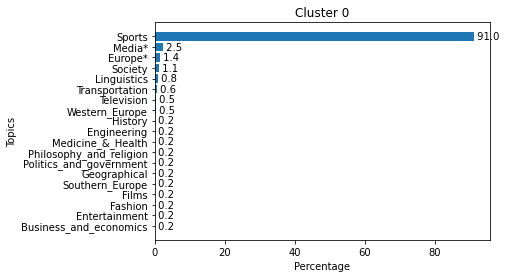

<Figure size 432x288 with 0 Axes>

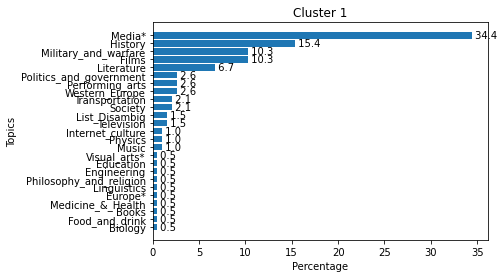

<Figure size 432x288 with 0 Axes>

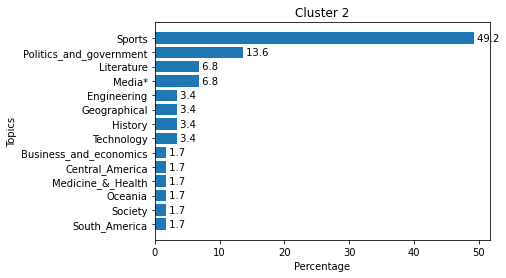

<Figure size 432x288 with 0 Axes>

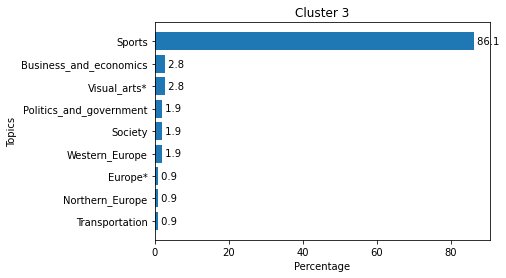

<Figure size 432x288 with 0 Axes>

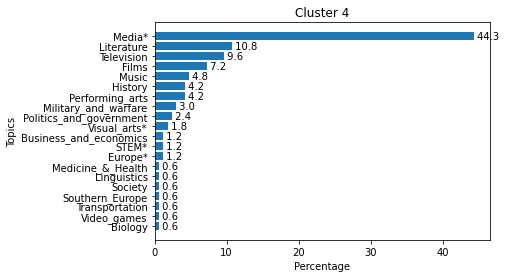

<Figure size 432x288 with 0 Axes>

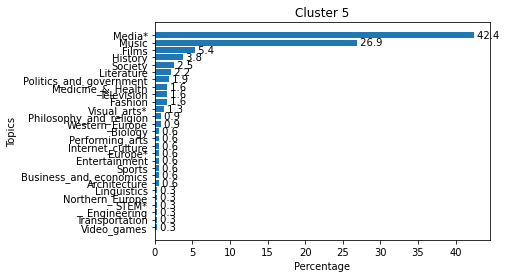

<Figure size 432x288 with 0 Axes>

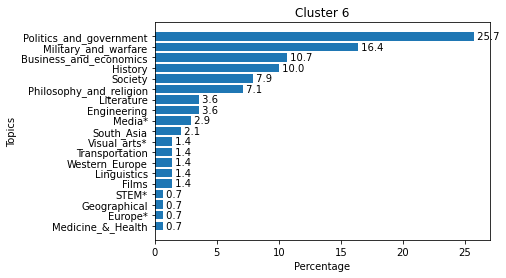

<Figure size 432x288 with 0 Axes>

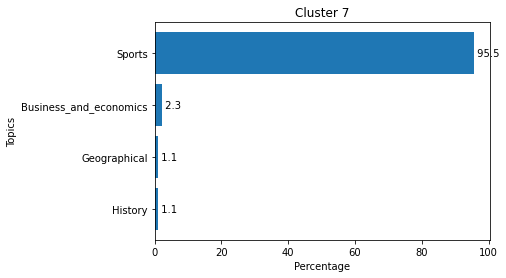

<Figure size 432x288 with 0 Axes>

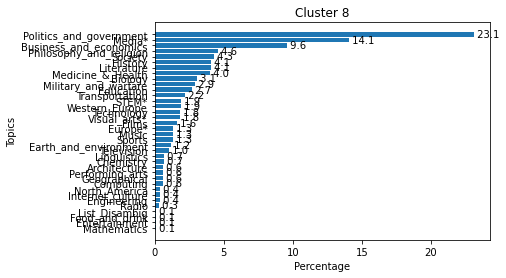

<Figure size 432x288 with 0 Axes>

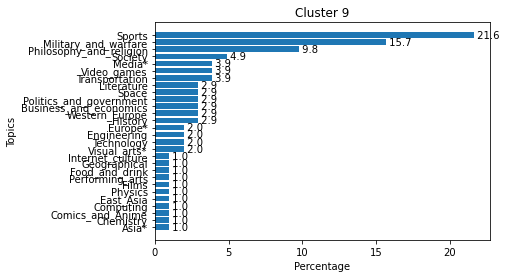

<Figure size 432x288 with 0 Axes>

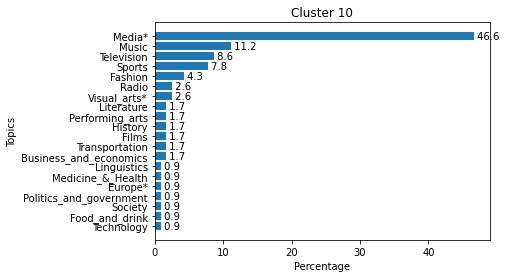

<Figure size 432x288 with 0 Axes>

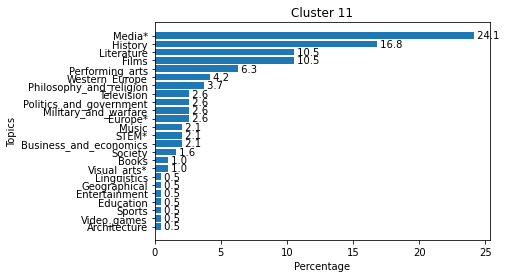

<Figure size 432x288 with 0 Axes>

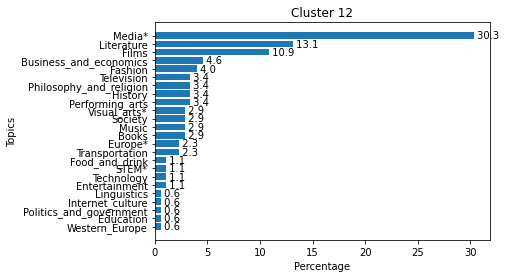

<Figure size 432x288 with 0 Axes>

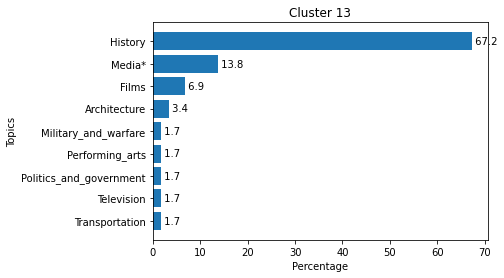

<Figure size 432x288 with 0 Axes>

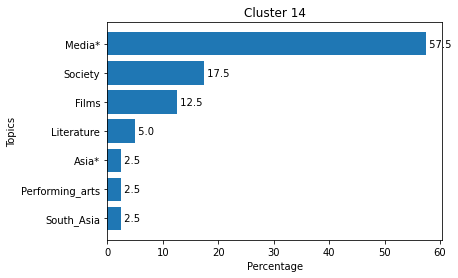

<Figure size 432x288 with 0 Axes>

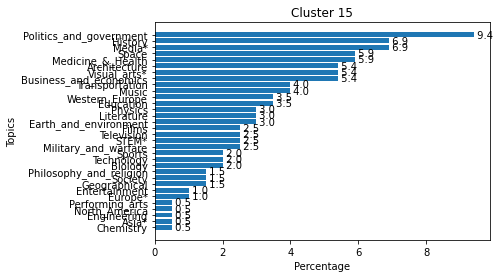

<Figure size 432x288 with 0 Axes>

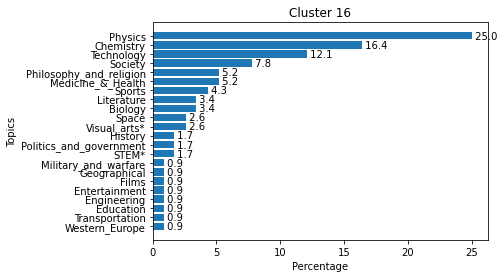

<Figure size 432x288 with 0 Axes>

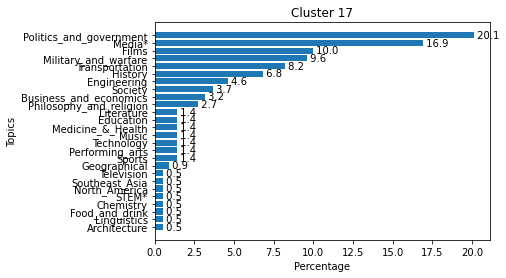

<Figure size 432x288 with 0 Axes>

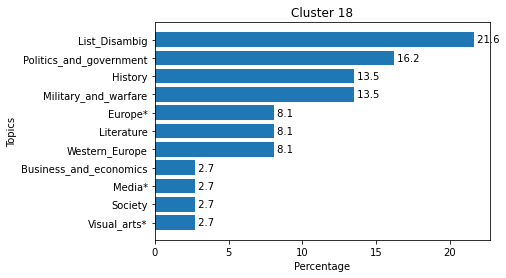

<Figure size 432x288 with 0 Axes>

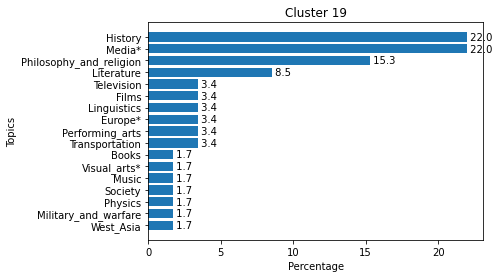

<Figure size 432x288 with 0 Axes>

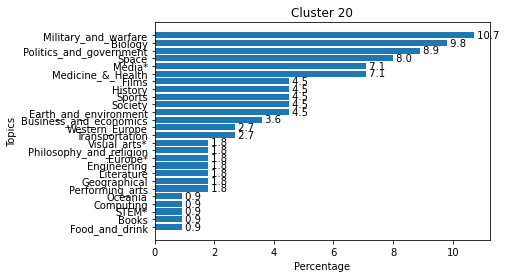

<Figure size 432x288 with 0 Axes>

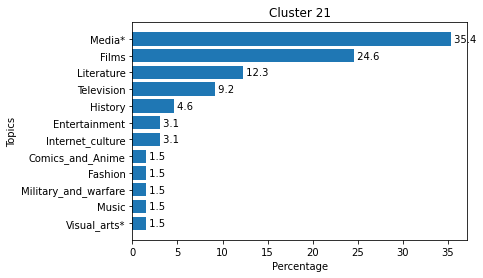

<Figure size 432x288 with 0 Axes>

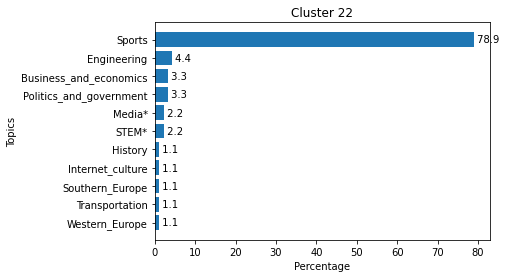

<Figure size 432x288 with 0 Axes>

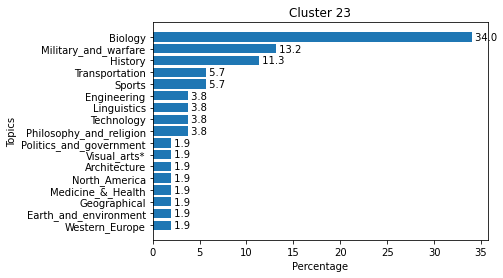

<Figure size 432x288 with 0 Axes>

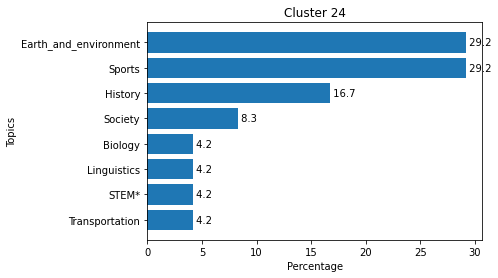

<Figure size 432x288 with 0 Axes>

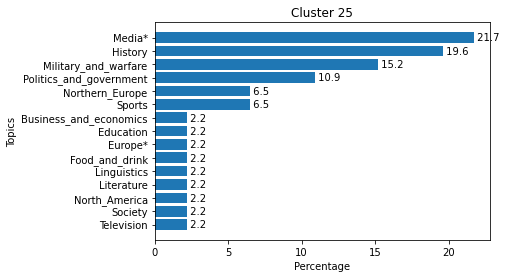

<Figure size 432x288 with 0 Axes>

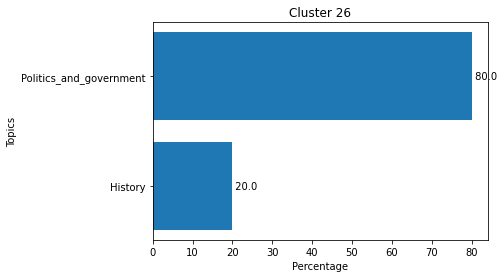

<Figure size 432x288 with 0 Axes>

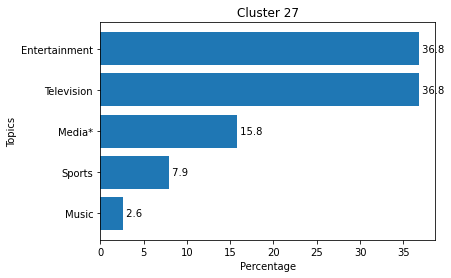

<Figure size 432x288 with 0 Axes>

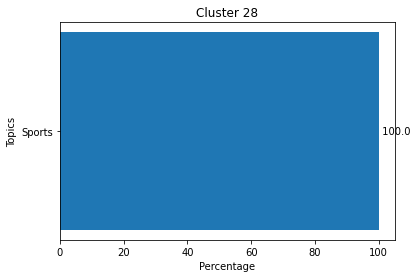

<Figure size 432x288 with 0 Axes>

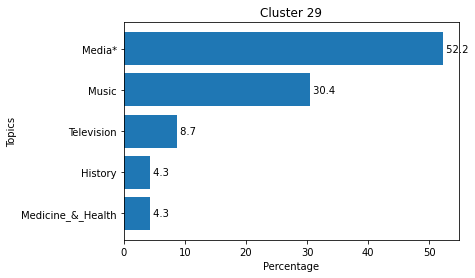

<Figure size 432x288 with 0 Axes>

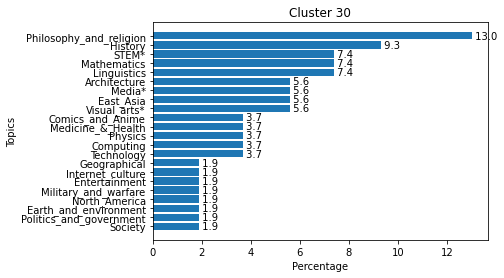

<Figure size 432x288 with 0 Axes>

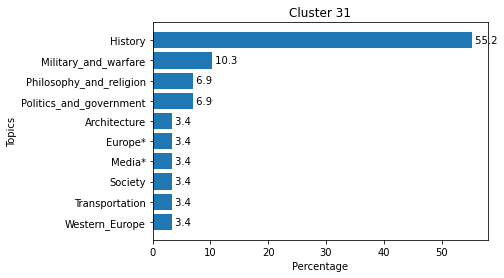

<Figure size 432x288 with 0 Axes>

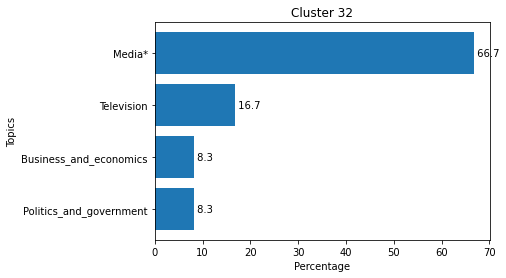

<Figure size 432x288 with 0 Axes>

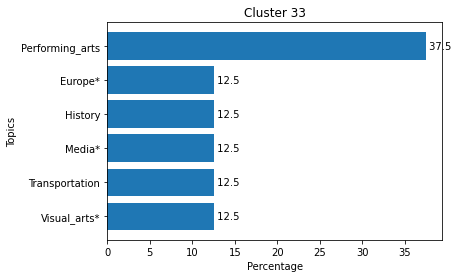

<Figure size 432x288 with 0 Axes>

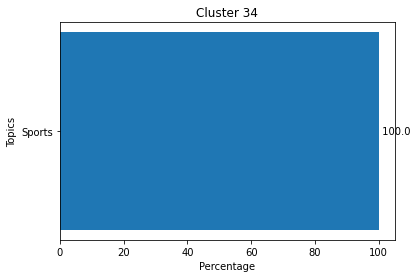

<Figure size 432x288 with 0 Axes>

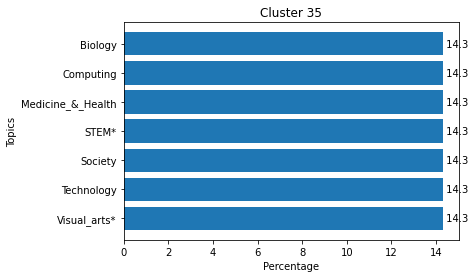

<Figure size 432x288 with 0 Axes>

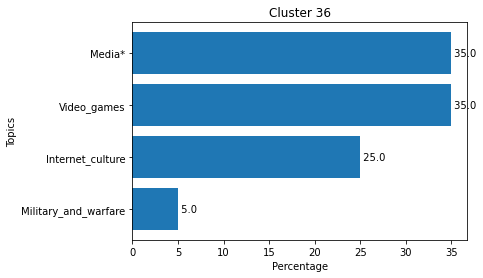

<Figure size 432x288 with 0 Axes>

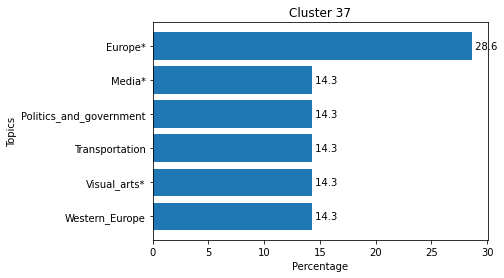

<Figure size 432x288 with 0 Axes>

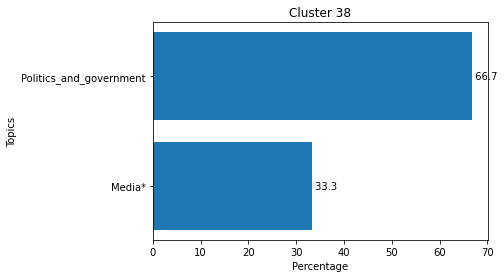

<Figure size 432x288 with 0 Axes>

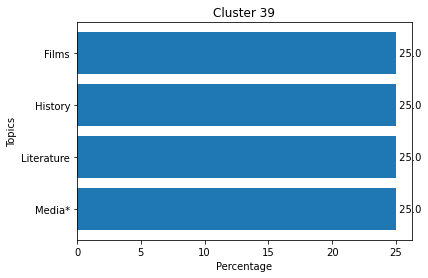

<Figure size 432x288 with 0 Axes>

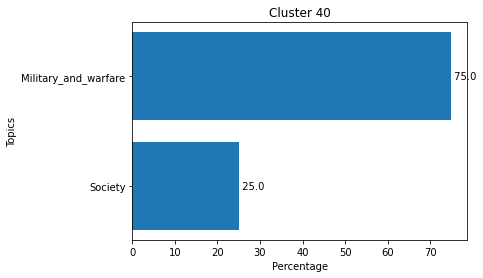

,Count,Ratio,Subtopic
modularity_class,,,
0,587,91.0,Sports
0,16,2.5,Media*
0,9,1.4,Europe*
0,7,1.1,Society
0,5,0.8,Linguistics
...,...,...,...
39,1,25.0,History
39,1,25.0,Literature
39,1,25.0,Media*


In [10]:
### Display a pie chart of the repartition of topics per cluster ###
### Save the number of each topic per cluster and their ratio ###
### Note : here only ignore 'Culture.Biography' topic ###


nodes = pd.read_csv(path + 'filled_nodes.csv', index_col = 'Unnamed: 0')

list_cluster_topic = pd.DataFrame()

# Create a folder for the figures
try:
    os.mkdir(path+'Figures')
except:
    pass

nb_cluster = int( nodes['modularity_class'].max() ) + 1
for cluster_id in range(nb_cluster):
    plt.figure(cluster_id)
    df = nodes.loc[(nodes['modularity_class'] == cluster_id) & (~nodes['Topic'].str.contains('Culture.Biography'))]
    
     # Avoid clusters without topics
    if (df.empty == True):
        df = nodes.loc[(nodes['modularity_class'] == cluster_id)]
        
    # Counting each topic and make a ratio over the total 
    df['Count'] = 1
    cluster = df.groupby(['Subtopic']).sum()['Count']
    df_cluster = pd.DataFrame(cluster)
    df_cluster['modularity_class'] = cluster_id
    df_cluster['Ratio'] = (cluster / cluster.sum() * 100).round(decimals=1)
    df_cluster['Subtopic'] = df_cluster.index
    df_cluster.set_index('modularity_class', inplace=True)
    df_cluster.sort_values(by = ['Count'], ascending = [False], inplace=True)
    list_cluster_topic = list_cluster_topic.append(df_cluster, ignore_index=False)
    
    
    # Making descending lists for plotting
    labels = list(df_cluster['Subtopic'])[::-1]
    ratio = list(df_cluster['Ratio'])[::-1]

    ind = np.arange(len(ratio))  
    height = 0.8
    
    fig1, ax1 = plt.subplots()
    ax1.barh(ind, ratio, height=height, align='center')
    
    # Labeling everything
    ax1.set_yticks(ind)
    ax1.set_yticklabels(labels)
    for i, v in enumerate(ratio):
        ax1.text(v, i, " "+str(v), color='black', va='center')
    plt.xlabel('Percentage')
    plt.ylabel('Topics')
    plt.title('Cluster ' + str(cluster_id))
    plt.savefig(path+'Figures/Cluster_' + str(cluster_id)+'.png', bbox_inches='tight', transparent=False, pad_inches=0.1)
    plt.show()

display(list_cluster_topic)

list_cluster_topic.to_csv(path + 'list_cluster_topic.csv', encoding='utf-8')